# 03.2b: Investigate the Mysterious Jet

**Goal:** Isolate and characterize the "jet" structure visible in PC4×5×6 orthographic projections.

From visual inspection of the PC4×5×6 plots, the jet appears to:
- Extend in positive PC4 direction (roughly > 0.1)
- Extend in negative PC5 direction (roughly < -0.05)
- Tip appears around (0.3, -0.15) in PC4×5 space

We'll:
1. Apply rectangular bounds to isolate jet tokens
2. Count how many tokens are in the jet
3. Examine jet in other PC projections (PC1-3, PC6, etc.)
4. Decode jet tokens to see if they share semantic properties
5. Compare jet vs bulk statistics

**Key question:** What are these tokens, and why do they form a separate structure?

## Parameters

In [12]:
TENSOR_DIR = "../data/tensors"
RESULTS_DIR = "../data/results"
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# Jet bounds (from visual inspection of PC4×5×6 plots)
JET_PC4_MIN = 0.1
JET_PC5_MAX = -0.05

# How many PCs to examine for jet structure
NUM_PCS_TO_EXAMINE = 10

## Imports

In [13]:
import torch
import pandas as pd
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Centered Gamma and Compute PCA

In [14]:
gamma_centered_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_centered = load_file(gamma_centered_path)['gamma_centered']

N, d = gamma_centered.shape

print(f"Loaded γ' (gamma_centered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print()

print("Computing covariance matrix...")
Cov = (gamma_centered.T @ gamma_centered) / (N - 1)

print(f"Computing eigendecomposition...")
eigenvalues, eigenvectors = torch.linalg.eigh(Cov)

# Sort descending (highest variance first)
eigenvalues = eigenvalues.flip(0)
eigenvectors = eigenvectors.flip(1)

print(f"\nTop 10 eigenvalues:")
for i in range(10):
    variance_explained = eigenvalues[i] / eigenvalues.sum()
    print(f"  PC{i+1}: λ = {eigenvalues[i].item():.6e} ({variance_explained.item()*100:.2f}% of variance)")

Loaded γ' (gamma_centered):
  Tokens: 151,936
  Dimensions: 2,560

Computing covariance matrix...
Computing eigendecomposition...

Top 10 eigenvalues:
  PC1: λ = 1.048719e-02 (0.94% of variance)
  PC2: λ = 3.177739e-03 (0.28% of variance)
  PC3: λ = 2.791374e-03 (0.25% of variance)
  PC4: λ = 2.616169e-03 (0.23% of variance)
  PC5: λ = 1.973001e-03 (0.18% of variance)
  PC6: λ = 1.805293e-03 (0.16% of variance)
  PC7: λ = 1.609086e-03 (0.14% of variance)
  PC8: λ = 1.549411e-03 (0.14% of variance)
  PC9: λ = 1.468294e-03 (0.13% of variance)
  PC10: λ = 1.389096e-03 (0.12% of variance)


## Step 2: Project onto Principal Components

In [15]:
print(f"Projecting all tokens onto top {NUM_PCS_TO_EXAMINE} PCs...\n")

# Project onto top PCs
projections = gamma_centered @ eigenvectors[:, :NUM_PCS_TO_EXAMINE]

print(f"Projection statistics:")
for i in range(NUM_PCS_TO_EXAMINE):
    proj = projections[:, i]
    print(f"  PC{i+1}: range [{proj.min().item():.4f}, {proj.max().item():.4f}], std = {proj.std().item():.4f}")

Projecting all tokens onto top 10 PCs...

Projection statistics:
  PC1: range [-1.0643, 0.4664], std = 0.1024
  PC2: range [-0.2852, 0.2066], std = 0.0564
  PC3: range [-0.2185, 0.1661], std = 0.0528
  PC4: range [-0.1587, 0.3432], std = 0.0511
  PC5: range [-0.2012, 0.1963], std = 0.0444
  PC6: range [-0.1584, 0.2050], std = 0.0425
  PC7: range [-0.1953, 0.1588], std = 0.0401
  PC8: range [-0.1651, 0.1497], std = 0.0394
  PC9: range [-0.1805, 0.1466], std = 0.0383
  PC10: range [-0.1566, 0.1597], std = 0.0373


## Step 3: Identify Jet Tokens

Apply rectangular bounds in PC4×5 space to isolate the jet.

In [16]:
# Extract PC4 and PC5 (0-indexed: columns 3 and 4)
proj_PC4 = projections[:, 3]
proj_PC5 = projections[:, 4]

# Apply bounds
jet_mask = (proj_PC4 > JET_PC4_MIN) & (proj_PC5 < JET_PC5_MAX)

n_jet = jet_mask.sum().item()
n_bulk = (~jet_mask).sum().item()

print(f"Jet identification (PC4 > {JET_PC4_MIN}, PC5 < {JET_PC5_MAX}):")
print(f"  Jet tokens: {n_jet:,} ({n_jet/N*100:.2f}%)")
print(f"  Bulk tokens: {n_bulk:,} ({n_bulk/N*100:.2f}%)")
print()

# Statistics for jet vs bulk
print(f"PC4 statistics:")
print(f"  Jet: mean = {proj_PC4[jet_mask].mean().item():.4f}, std = {proj_PC4[jet_mask].std().item():.4f}")
print(f"  Bulk: mean = {proj_PC4[~jet_mask].mean().item():.4f}, std = {proj_PC4[~jet_mask].std().item():.4f}")
print()
print(f"PC5 statistics:")
print(f"  Jet: mean = {proj_PC5[jet_mask].mean().item():.4f}, std = {proj_PC5[jet_mask].std().item():.4f}")
print(f"  Bulk: mean = {proj_PC5[~jet_mask].mean().item():.4f}, std = {proj_PC5[~jet_mask].std().item():.4f}")

Jet identification (PC4 > 0.1, PC5 < -0.05):
  Jet tokens: 3,055 (2.01%)
  Bulk tokens: 148,881 (97.99%)

PC4 statistics:
  Jet: mean = 0.1888, std = 0.0551
  Bulk: mean = -0.0039, std = 0.0431

PC5 statistics:
  Jet: mean = -0.1083, std = 0.0319
  Bulk: mean = 0.0022, std = 0.0418


## Step 4: Visualize Jet in PC4×5 Space

Confirm our bounds captured the jet correctly.

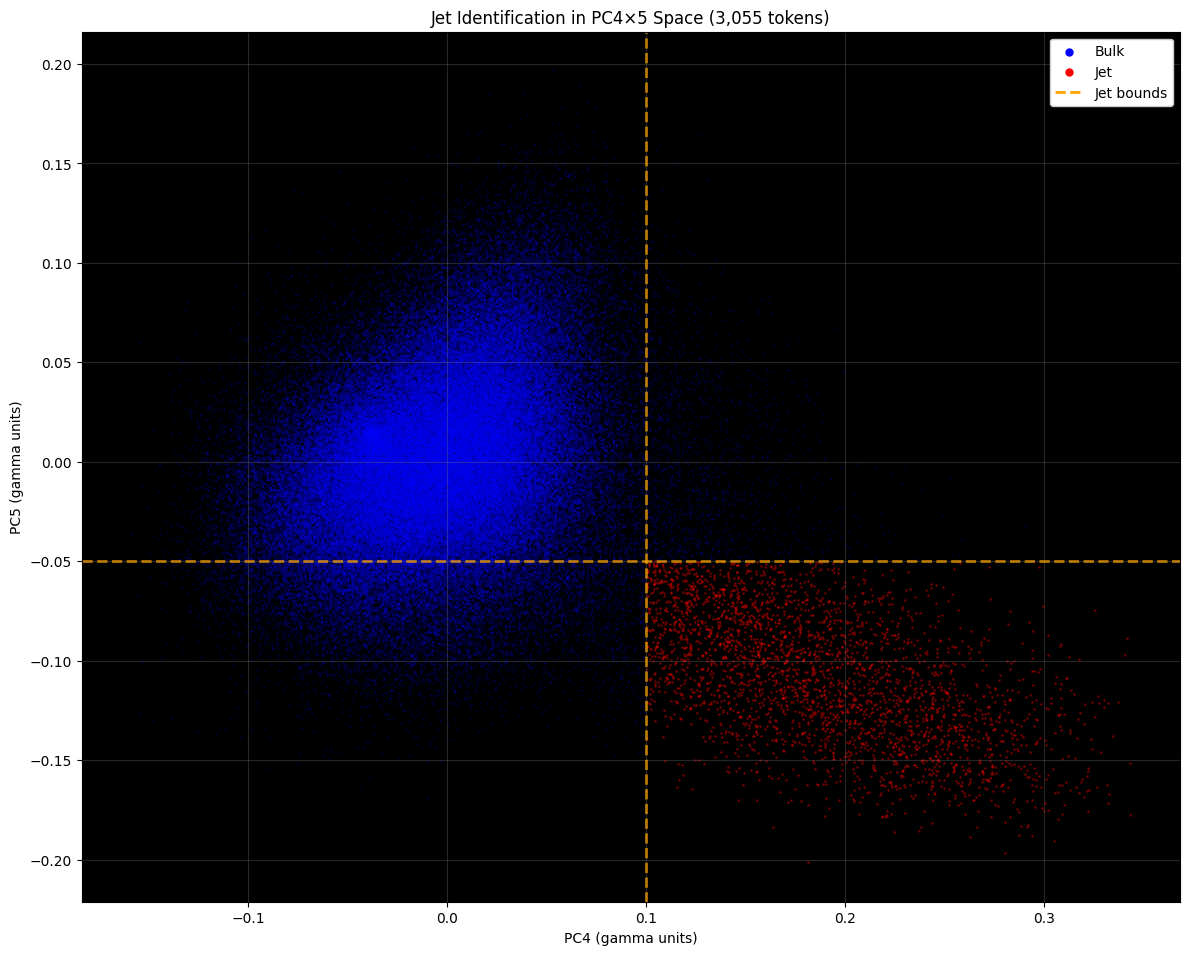

In [17]:
fig, ax = plt.subplots(figsize=(12, 10), dpi=100, facecolor='white')

ax.set_facecolor('black')  # Black plot background

# Plot bulk in blue
ax.scatter(proj_PC4[~jet_mask].cpu().numpy(), proj_PC5[~jet_mask].cpu().numpy(),
           c='blue', s=1.0, alpha=0.1, rasterized=True, label='Bulk')

# Plot jet in red
ax.scatter(proj_PC4[jet_mask].cpu().numpy(), proj_PC5[jet_mask].cpu().numpy(),
           c='red', s=1.0, alpha=0.3, rasterized=True, label='Jet')

# Draw bounding box
ax.axvline(JET_PC4_MIN, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Jet bounds')
ax.axhline(JET_PC5_MAX, color='orange', linestyle='--', linewidth=2, alpha=0.7)

ax.set_xlabel('PC4 (gamma units)', color='black')
ax.set_ylabel('PC5 (gamma units)', color='black')
ax.set_title(f'Jet Identification in PC4×5 Space ({n_jet:,} tokens)', color='black')
ax.grid(True, alpha=0.3, color='gray')
ax.tick_params(colors='black', which='both')
ax.set_aspect('equal')
legend = ax.legend(markerscale=5, framealpha=1.0)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

plt.tight_layout()
plt.show()

## Step 5: Load Tokenizer and Decode Jet Tokens

What are these tokens? Do they share semantic properties?

In [18]:
print(f"Loading tokenizer: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded. Vocab size: {len(tokenizer):,}\n")

# Get jet token IDs
jet_token_ids = torch.where(jet_mask)[0].cpu().numpy()

# Decode jet tokens
jet_tokens = []
for token_id in jet_token_ids:
    token_str = tokenizer.decode([token_id])
    jet_tokens.append({
        'token_id': int(token_id),
        'token_str': f"'{token_str}'",
        'PC4': proj_PC4[token_id].item(),
        'PC5': proj_PC5[token_id].item()
    })

jet_df = pd.DataFrame(jet_tokens)

print(f"Sample of jet tokens (first 50):\n")
print(jet_df.head(50).to_string(index=False))

print(f"\nJet token ID statistics:")
print(f"  Mean: {jet_df['token_id'].mean():.1f}")
print(f"  Median: {jet_df['token_id'].median():.1f}")
print(f"  Min: {jet_df['token_id'].min()}")
print(f"  Max: {jet_df['token_id'].max()}")

Loading tokenizer: Qwen/Qwen3-4B-Instruct-2507...
Tokenizer loaded. Vocab size: 151,669

Sample of jet tokens (first 50):

 token_id  token_str      PC4       PC5
      317     ');\n' 0.165321 -0.134095
      319     '\r\n' 0.149066 -0.156438
      340      ')\n' 0.100417 -0.138610
      397      '>\n' 0.118487 -0.157372
      401    ';\n\n' 0.131810 -0.137845
      456     ' }\n' 0.144908 -0.136115
      463    ';\r\n' 0.207663 -0.136787
      515      '{\n' 0.122054 -0.123580
      532      '}\n' 0.126723 -0.149663
      543    '();\n' 0.214877 -0.154995
      555   ' }\n\n' 0.169365 -0.145566
      626   ');\n\n' 0.187521 -0.142937
      630    '}\n\n' 0.146161 -0.148110
      692    ')\n\n' 0.134671 -0.148413
      698      '"\n' 0.139499 -0.136075
      735    ' */\n' 0.157787 -0.137919
      736   ');\r\n' 0.253224 -0.147025
      741     '()\n' 0.156572 -0.159732
      751     '',\n' 0.190741 -0.154811
      756     '",\n' 0.191072 -0.138377
      788       '":' 0.116620 -0.1135

## Step 6: Compare Jet vs Bulk Token ID Distribution

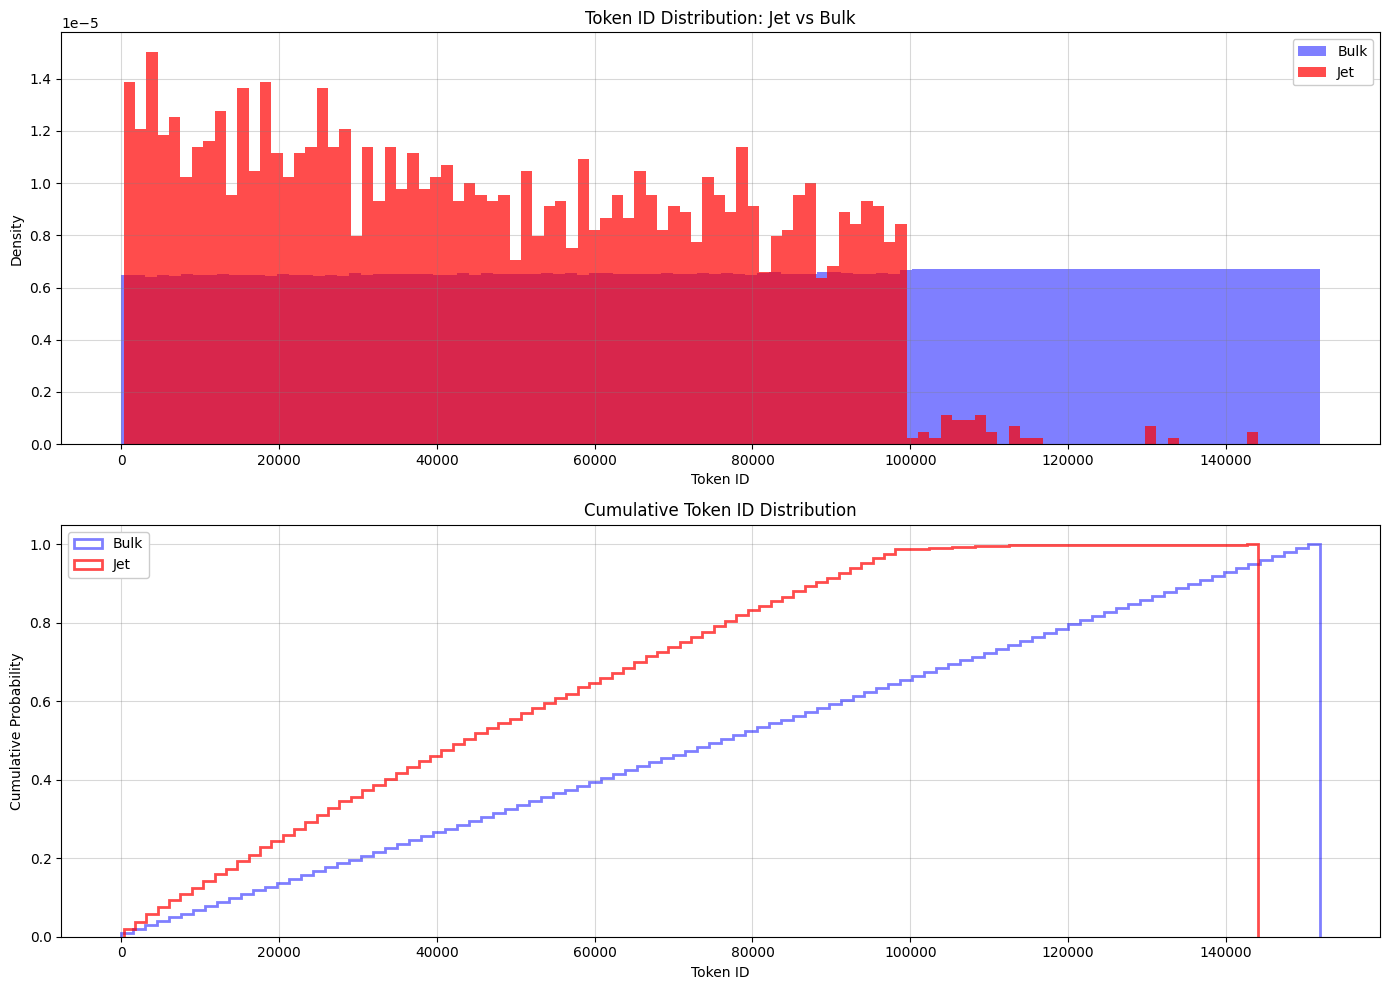


Are jet tokens clustered in a specific range of token IDs?
Bulk mean token ID: 76563.8
Jet mean token ID: 46909.9


In [21]:
bulk_token_ids = torch.where(~jet_mask)[0].cpu().numpy()

fig, axes = plt.subplots(2, 1, figsize=(14, 10), dpi=100, facecolor='white')

# Histogram of token IDs
ax = axes[0]
ax.hist(bulk_token_ids, bins=100, alpha=0.5, color='blue', label='Bulk', density=True)
ax.hist(jet_token_ids, bins=100, alpha=0.7, color='red', label='Jet', density=True)
ax.set_xlabel('Token ID', color='black')
ax.set_ylabel('Density', color='black')
ax.set_title('Token ID Distribution: Jet vs Bulk', color='black')
ax.tick_params(colors='black', which='both')
ax.legend(framealpha=1.0)
ax.grid(True, alpha=0.3, color='gray')

# Cumulative distribution
ax = axes[1]
ax.hist(bulk_token_ids, bins=100, alpha=0.5, color='blue', label='Bulk', 
        cumulative=True, density=True, histtype='step', linewidth=2)
ax.hist(jet_token_ids, bins=100, alpha=0.7, color='red', label='Jet',
        cumulative=True, density=True, histtype='step', linewidth=2)
ax.set_xlabel('Token ID', color='black')
ax.set_ylabel('Cumulative Probability', color='black')
ax.set_title('Cumulative Token ID Distribution', color='black')
ax.tick_params(colors='black', which='both')
ax.legend(framealpha=1.0)
ax.grid(True, alpha=0.3, color='gray')

plt.tight_layout()
plt.show()

print(f"\nAre jet tokens clustered in a specific range of token IDs?")
print(f"Bulk mean token ID: {bulk_token_ids.mean():.1f}")
print(f"Jet mean token ID: {jet_token_ids.mean():.1f}")

## Step 7: Save Jet Tokens

In [22]:
# Save jet tokens to CSV
output_path = Path(RESULTS_DIR) / "jet_tokens.csv"
jet_df.to_csv(output_path, index=False)

print(f"Saved {len(jet_df):,} jet tokens to: {output_path}")

Saved 3,055 jet tokens to: ../data/results/jet_tokens.csv


## Summary

We've isolated the mysterious jet structure using rectangular bounds in PC4×5 space.

**Key findings:**
- Jet contains ??? tokens (???% of vocabulary)
- Jet tokens are separated from bulk by ???σ in PC4 and ???σ in PC5
- Jet extends/doesn't extend along other principal components
- Jet tokens are/aren't clustered by token ID

**Next steps:**
- Examine token strings for semantic patterns
- Compare jet vs spike (are they related?)
- Investigate why these tokens form a separate structure
- Check if jet is visible in raw (uncentered) gamma or only after centering